In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import array
from scipy.io import savemat
import scipy.io
import argparse
import numpy as np
from skimage import io, util
from sklearn.feature_extraction import image
from sklearn import preprocessing
from ksvd import ApproximateKSVD
import tqdm

In [10]:
blm = np.fromfile('data/nu_hat_blm.bin', dtype=np.float64).reshape(181,217).T[50:150,:100]
orig = np.fromfile('data/nu.bin', dtype=np.float64).reshape(181,217).T[50:150,:100]
fz = np.fromfile('data/fz.bin', dtype=np.float64).reshape(181,217).T[50:150,:100]
z = np.fromfile('data/z.bin', dtype=np.float64).reshape(181,217).T[50:150,:100]


### Patch representation and KSVD

In [19]:
def _ksvd(img):

    global patch_shape
    
    patch_size = (4, 4)
    patches = image.extract_patches_2d(img, patch_size)

    patch_shape = patches.shape
    print(patches.shape)  # (6, 10, 1, 512, 512, 3)

    signals = patches.reshape(patches.shape[0], -1)

    mean = np.mean(signals, axis=1)[:, np.newaxis]

    

    signals -= mean

    aksvd = ApproximateKSVD(n_components=20)

    D = aksvd.fit(signals[:10000])

    dictionary = D.components_

    A = aksvd.transform(signals)
    
    return(A, dictionary, mean, patches)

def reweight(A, dictionary, mean, patches):
    
    weights  = (A!=0).sum(axis=0)/(A!=0).sum()
    
    delta =5
    weights_matrix = np.diag(weights*delta+1)

    D_prime = np.matmul(weights_matrix,dictionary)
    reduced = A.dot(D_prime) + mean

    reduced_img = image.reconstruct_from_patches_2d(
        reduced.reshape(patches.shape), img.shape)
    
    return( D_prime, reduced,reduced_img)

In [21]:
#A,D_prime,reduced,reduced_img = _ksvd(fz)
img = fz
A, dictionary,mean, patches = _ksvd(fz)
D_prime,reduced,reduced_img = reweight(A, dictionary, mean, patches)
#_,_,_,reduced_img_z = _ksvd(z)

(9409, 4, 4)


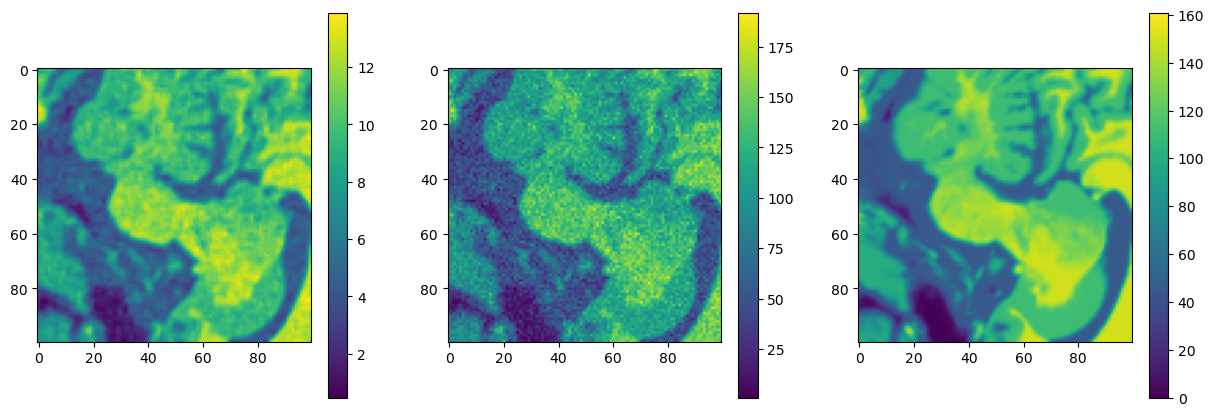

In [22]:
plt.figure(figsize =(15,5))

plt.subplot(131)
plt.imshow(reduced_img)
plt.colorbar()

plt.subplot(132)
plt.imshow(z)
plt.colorbar()


plt.subplot(133)
plt.imshow(orig)
plt.colorbar()

####  Next step: creating I, M,CSS,SS

In [23]:
I = {}
for i,row in enumerate(reduced):
    I[i] = []
    for j in range(D_prime.shape[0]):
        if A[i,j]!=0:
            I[i].append(j)

    

In [24]:
M={}
for i in I:
    if len(I[i])==0:
        M[i] = None
    else:
        M[i]= abs(A[I[i]]).argmax()
        

In [26]:
CSS={}
for i in tqdm.tqdm(I):
    CSS[i] = []
    if len(I[i])==0:
        continue
    for j in M:
        if M[j] in I[i]:
            CSS[i].append(j)

100%|██████████████████████████████████████| 9409/9409 [00:14<00:00, 661.94it/s]


In [27]:
SS = {}
for i in tqdm.tqdm(CSS):
    SS[i] = [reduced[i]]
    if len(CSS[i])==0:
        continue
    for j in CSS[i]:
        if np.linalg.norm(reduced[i]-reduced[j])/np.linalg.norm(reduced[i])<0.07:
            SS[i].append(reduced[j])
    

100%|██████████████████████████████████████| 9409/9409 [00:26<00:00, 350.81it/s]


####  SVD of similar patches

In [28]:
y_hat = reduced.copy()

for i in SS:
    u, s, vh = scipy.linalg.svd(SS[i], full_matrices=False)# Remove sigma values below threshold (250)

    s_cleaned = np.array([s[i] if i<20 else 0 for i in range(len(s))])# Calculate A' = U * Σ (cleaned) * V

    img_denoised = np.array(np.dot(u * s_cleaned, vh), dtype=int)
    y_hat[i] = np.mean(SS[i],axis=0)

In [30]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


In [31]:
reduced_hat = image.reconstruct_from_patches_2d(y_hat.reshape(patch_shape), z.shape)

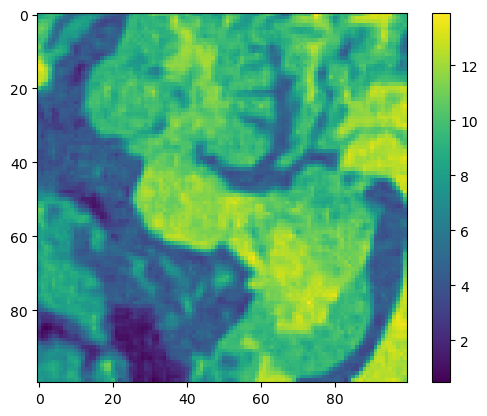

In [32]:
plt.imshow(reduced_hat)
plt.colorbar()

In [271]:
res_ksvd={} 
res_ksvd['fz'] = reduced_img 

savemat('transformed_ksvd.mat',res_ksvd)


res ={}
res['fz'] = all_pics[ 'averaging']
savemat('transformed.mat',res)

In [274]:
all_vst = {}
all_vst['reference'] = all_pics['reference']
all_vst['distorted'] = distorted

all_vst['vst'] = vst

all_vst['ksvd'] = ksvd
all_vst['nonlocal'] = non_local

all_vst['svd'] = svd

all_vst['averaging'] = averaging




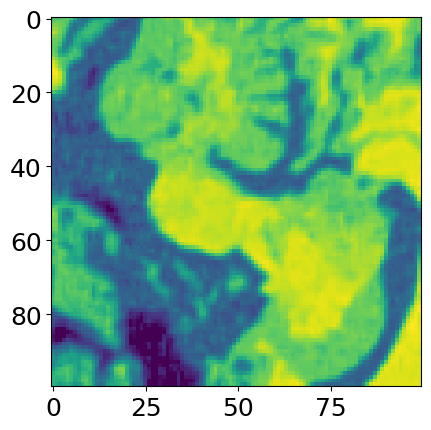

In [273]:
plt.imshow(averaging)